### Load Data & libraries

In [1]:
import numpy as np
import pandas as pd
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
import time


In [2]:
# Load data
data = read_csv(r"C:\Users\zhouq\OneDrive - Nanyang Technological University\FYP\Codes\FYP\Data_transform.csv", header = 0, index_col=0, parse_dates=True, dayfirst=False)

# Select 3 exogenous variables 
# M1: Industrial Production Index
# M7: Retail and Food Services Sale
# M12: Effective Federal Funds Rate 

data_new = data[['GDP', 'M1', 'M7','M12']]
data_new = data_new.dropna()

# Split the data into training and testing sets
train_size = int(len(data_new) * 0.8)

GDP_fill_data  = pd.DataFrame(data_new['GDP'])
GDP_fill_data.index = GDP_fill_data.index + pd.offsets.QuarterEnd(0)
GDP_fill_data_train, GDP_fill_data_test = GDP_fill_data[:train_size], GDP_fill_data[train_size:]
display(GDP_fill_data )

x_data = pd.DataFrame(data_new.iloc[:, 1:])
x_train, x_test = x_data[:train_size], x_data[train_size:]
display(x_data)


,GDP
Date,
1959-06-30,0.022301
1959-09-30,0.000705
1959-12-31,0.002845
1960-03-31,0.022228
1960-06-30,-0.005405
...,...
2018-12-31,0.002229
2019-03-31,0.005960
2019-06-30,0.007898


,M1,M7,M12
Date,,,
1959-06-30,0.012391,0.005828,0.196667
1959-09-30,-0.019971,-0.002374,0.123333
1959-12-31,0.019589,-0.008020,0.076667
1960-03-31,0.002654,0.009733,-0.050000
1960-06-30,-0.007252,0.003164,-0.173333
...,...,...,...
2018-12-31,-0.000848,-0.002520,0.106667
2019-03-29,-0.003236,0.009089,0.046667
2019-06-28,-0.001557,0.003632,-0.010000


### Set up ESN

In [6]:
from LibESN.matrix_generator import matrixGenerator
from LibESN.esn import ESN

# construct individual ESN
# K is size of inputs 
K = int(x_data.shape[1])
print(int(x_data.shape[1]))

# build single reservoir ESN with reservoir dim = 30, sparsity = 10/30 (33.3%)

esn_a = ESN(
    None,
    smap=np.tanh, 
    A=matrixGenerator((30, 30), dist='sparse_normal', sparsity=10/30, seed=1234), 

    C=matrixGenerator((30, K), dist='sparse_uniform', sparsity=10/30, seed=1234), 

    zeta=np.zeros((30, 1)), 
    rho=0.5, 
    gamma=1, 
    leak=0,
)


3


In [ ]:
# ESN with reservoir dim = 120, sparsity = 10/120 (8.3%)
esn_b = ESN(
    None,
    smap=np.tanh, 
    A=matrixGenerator((120, 120), dist='sparse_normal', sparsity=10/120, seed=1234), 

    C=matrixGenerator((120, K), dist='sparse_uniform', sparsity=10/120, seed=1234), 

    zeta=np.zeros((120, 1)), 
    rho=0.5, 
    gamma=1, 
    leak=0,
)

# ESN with reservoir dim = 250 > 193 (N > T), sparsity = 10/250 (4.0%)
esn_c = ESN(
    None,
    smap=np.tanh, 
    A=matrixGenerator((250 , 250), dist='sparse_normal', sparsity=10/250, seed=1234), 

    C=matrixGenerator((250, K), dist='sparse_uniform', sparsity=10/250, seed=1234), 

    zeta=np.zeros((250, 1)), 
    rho=0.5, 
    gamma=1, 
    leak=0,
)

In [9]:
from LibESN.esn_fit import ridgeFit, ridgeCV

# ridge regression with CV to fit single ESN -- test size by default is 1 --> Leave-One-Out CV; one step ahead 

cv_a = ridgeCV().cv(model = esn_a, train_data=(x_train, GDP_fill_data_train), steps = 1 )

cv_b = ridgeCV().cv(model = esn_b, train_data=(x_train, GDP_fill_data_train), steps = 1 )

cv_c = ridgeCV().cv(model = esn_c, train_data=(x_train, GDP_fill_data_train), steps = 1 )

In [ ]:
print(cv_a['cvLambda'])
print(cv_b['cvLambda'])
print(cv_c['cvLambda'])

4.912552924960565
99551.66942741635


#### Model Fitting

In [12]:
# model fitting
esn_fit_a = esn_a.fit(train_data =(x_train, GDP_fill_data_train), method=ridgeFit(cv_a['cvLambda']), steps=1)

esn_fit_b = esn_b.fit(train_data =(x_train, GDP_fill_data_train), method=ridgeFit(cv_b['cvLambda']), steps=1)

esn_fit_c = esn_c.fit(train_data =(x_train, GDP_fill_data_train), method=ridgeFit(cv_c['cvLambda']), steps=1)

display(esn_fit_a)
display(esn_fit_b)
display(esn_fit_c)

{'model': 'ESN',
 'method': 'ridgeFit',
 'W': array([[ 8.20301765e-03],
        [ 1.67713820e-05],
        [ 6.04590151e-05],
        [ 1.40542531e-04],
        [ 7.68562963e-05],
        [-2.30439091e-05],
        [-7.78925438e-05],
        [ 7.58574680e-06],
        [ 6.64303394e-06],
        [-9.17297729e-05],
        [-1.22540096e-04],
        [ 8.23743806e-05],
        [-4.88962021e-05],
        [-1.35315031e-04],
        [ 2.54348004e-05],
        [ 4.05921650e-05],
        [-7.06878554e-05],
        [ 1.18530541e-04],
        [ 6.23845221e-05],
        [ 6.18430574e-05],
        [-8.08994125e-05],
        [-1.12323328e-05],
        [-2.05714309e-05],
        [-3.51715791e-05],
        [ 3.59770680e-05],
        [ 1.25142760e-04],
        [ 5.62454055e-05],
        [ 1.35287857e-06],
        [ 2.06769270e-05],
        [-2.58930595e-05],
        [ 4.00650700e-06]]),
 'states': array([[-0.15562328,  0.        ,  0.17410637, ...,  0.00103759,
          0.10290073,  0.        ],
    

{'model': 'ESN',
 'method': 'ridgeFit',
 'W': array([[ 8.24061475e-03],
        [ 8.84654026e-10],
        [-1.18527913e-09],
        [-6.27012701e-10],
        [-4.73902418e-09],
        [-3.44603781e-09],
        [ 1.88973377e-09],
        [ 3.84610955e-09],
        [ 1.85523487e-09],
        [ 6.40445565e-09],
        [ 1.84775174e-09],
        [ 1.35310596e-08],
        [ 2.91614366e-09],
        [-2.26665253e-09],
        [-8.91231853e-09],
        [ 1.87168727e-09],
        [-6.00288755e-09],
        [-2.89696494e-09],
        [ 1.72257272e-09],
        [-2.52245712e-09],
        [-1.07617736e-09],
        [-1.69255031e-09],
        [-8.58352052e-10],
        [ 3.96195684e-09],
        [-2.54481546e-09],
        [ 3.82061126e-10],
        [ 5.33441475e-09],
        [ 8.35304959e-10],
        [-2.58986207e-09],
        [-2.03945884e-09],
        [ 7.31834930e-09],
        [ 1.42826233e-09],
        [-2.64228213e-09],
        [-1.42726577e-09],
        [-5.44607520e-09],
        [-

{'model': 'ESN',
 'method': 'ridgeFit',
 'W': array([[ 8.23951642e-03],
        [-8.94848745e-08],
        [-2.08319424e-07],
        [ 6.95361694e-08],
        [ 2.76390256e-07],
        [-8.15290256e-08],
        [-2.70634085e-07],
        [ 3.16711932e-07],
        [ 7.54540863e-07],
        [ 3.27463296e-07],
        [ 5.49704831e-07],
        [-4.41618335e-07],
        [ 4.56603741e-07],
        [-3.54210073e-08],
        [-4.38799447e-07],
        [-2.10035179e-07],
        [ 4.97274007e-08],
        [ 3.41850045e-08],
        [-1.75283815e-07],
        [-6.12543035e-07],
        [-1.60072069e-07],
        [ 8.89144400e-08],
        [ 7.39278127e-08],
        [ 3.96782197e-07],
        [ 9.71860223e-08],
        [-4.18439319e-07],
        [-4.47538574e-07],
        [-7.73376650e-08],
        [-1.05533208e-07],
        [-2.75870584e-07],
        [-1.08419202e-07],
        [-2.76200598e-07],
        [-2.40979765e-07],
        [-5.78194533e-07],
        [ 1.26102156e-07],
        [ 

In [13]:
# one step ahead forecast - fixed parameters
from LibESN.esn_forecast import forecast

forecast_a = forecast(
    model=esn_a,
    forecast_data=x_test,
    fit=esn_fit_a)

forecast_b = forecast(
    model=esn_b,
    forecast_data=x_test,
    fit=esn_fit_b)

forecast_c = forecast(
    model=esn_c,
    forecast_data=x_test,
    fit=esn_fit_c)

len(forecast_a['forecast'])

50

In [16]:
# Evaluate the model esn_a
print('Results for ESN_a')
mse_a = mean_squared_error(GDP_fill_data_test, forecast_a['forecast'][0:49])
print('MSE: '+str(mse_a))

mae = mean_absolute_error(GDP_fill_data_test, forecast_a['forecast'][0:49])
print('MAE: '+str(mae))

rmse = math.sqrt(mse_a)
print('RMSE: '+str(rmse))

# Evaluate the model esn_b
print('Results for ESN_b')
mse_b = mean_squared_error(GDP_fill_data_test, forecast_b['forecast'][0:49])
print('MSE: '+str(mse_b))

mae = mean_absolute_error(GDP_fill_data_test, forecast_b['forecast'][0:49])
print('MAE: '+str(mae))

rmse = math.sqrt(mse_b)
print('RMSE: '+str(rmse))

# Evaluate the model esn_c
print('Results for ESN_c')
mse_c = mean_squared_error(GDP_fill_data_test, forecast_c['forecast'][0:49])
print('MSE: '+str(mse_c))

mae = mean_absolute_error(GDP_fill_data_test, forecast_c['forecast'][0:49])
print('MAE: '+str(mae))

rmse = math.sqrt(mse_c)
print('RMSE: '+str(rmse))


Results for ESN_a
MSE: 5.3090665914845315e-05
MAE: 0.004784522119666634
RMSE: 0.007286334189072398
Results for ESN_b
MSE: 5.234969098038961e-05
MAE: 0.004752434277564051
RMSE: 0.007235308630624516
Results for ESN_c
MSE: 5.236129709042405e-05
MAE: 0.004753180093502099
RMSE: 0.0072361106328209255


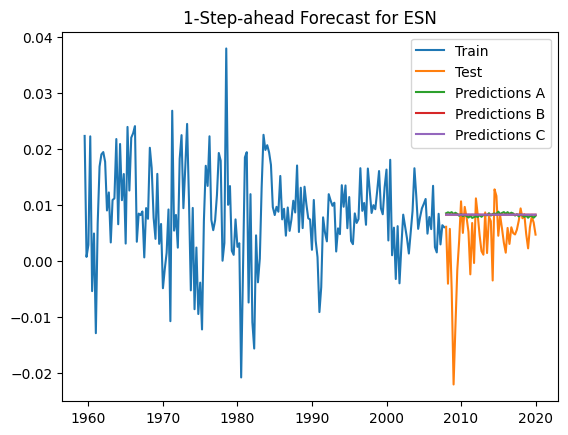

In [17]:
# Plot the actual vs. predicted values
plt.plot(data_new.index[:len(GDP_fill_data_train)], GDP_fill_data_train, label='Train')
plt.plot(data_new.index[len(GDP_fill_data_train):],GDP_fill_data_test, label='Test')
plt.plot(data_new.index[len(GDP_fill_data_train):], forecast_a['forecast'][1:], label='Predictions A')
plt.plot(data_new.index[len(GDP_fill_data_train):], forecast_b['forecast'][1:], label='Predictions B')
plt.plot(data_new.index[len(GDP_fill_data_train):], forecast_c['forecast'][1:], label='Predictions C')
plt.legend()
plt.title("1-Step-ahead Forecast for ESN")
plt.show()

#### Setting up with newToolbox_ESN

In [3]:
from newToolbox_ESN import ESN, stateMatrixGenerator, identity
from newToolbox_ESN import ESN
from newToolbox_ESN_Multi import ESNMultiFrequency

K = int(x_data.shape[1])

esn_S_A = ESN(
    N=30,
    A=stateMatrixGenerator(
        (30, 30), 
        dist='sparse_normal', sparsity=10/30, normalize='eig',
        seed=1234
    ),
    C=stateMatrixGenerator(
        (30, int(K)), 
        dist='sparse_uniform', sparsity=10/30, normalize='norm2',
        seed=1234
    ),
    rho=0.5,
    gamma=1,
    leak_rate=0,
    activation=np.tanh,
)

esnSingle_A = ESNMultiFrequency((esn_S_A,), ar=False)

In [7]:
esn_S_B = ESN(
    N=120,
    A=stateMatrixGenerator(
        (120, 120), 
        dist='sparse_normal', sparsity=10/30, normalize='eig',
        seed=1234
    ),
    C=stateMatrixGenerator(
        (120, int(K)), 
        dist='sparse_uniform', sparsity=10/120, normalize='norm2',
        seed=1234
    ),
    rho=0.5,
    gamma=1,
    leak_rate=0,
    activation=np.tanh,
)

esnSingle_B = ESNMultiFrequency((esn_S_B,), ar=False)

ESNMultiFrequency.ridge_lambda_cv()
. Method:
['ridge']
[]
[]
. CV Options:
['cv', 'test_size']
['10', '1']
. Folds built


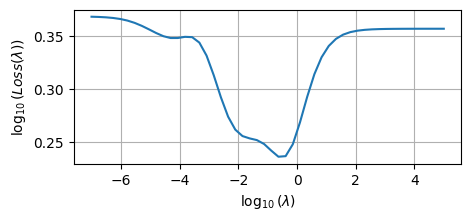

+ s = 0 --------------------
Best solution found:
lambda = [0.30275363]
F      = 1.7192900112696017


[array([0.30275363])]

In [16]:
# use CV to find lambda -- take test size = 1 so rest of data used for training
esnSingle_A_cv10 = esnSingle_A.ridge_lambda_cv(Y = GDP_fill_data_train, z = (x_train, ), method="ridge",
    cv_options="-cv:10-test_size:1",
    steps=1,
    debug=True )

esnSingle_A_cv10

ESNMultiFrequency.ridge_lambda_cv()
. Method:
['ridge']
['isotropic']
[]
. CV Options:
['cv', 'test_size']
['10', '1']
. Folds built


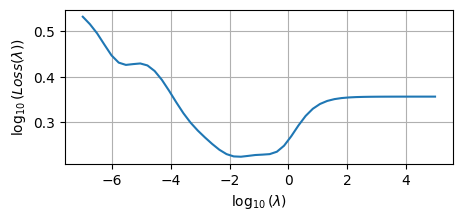

+ s = 0 --------------------
Best solution found:
lambda = [0.02024865]
F      = 1.6757118313355048


[array([0.02024865])]

In [15]:
esnSingle_B_cv10 = esnSingle_B.ridge_lambda_cv(Y = GDP_fill_data_train, z = (x_train, ), method="ridge-isotropic",
    cv_options="-cv:10-test_size:1",
    steps=1,
    debug=True )

esnSingle_B_cv10

In [15]:
# fit with ridge regression
esnSingle_A_fit = esnSingle_A.fit(Y = GDP_fill_data_train, z= (x_test, ), method ='ridge', Lambda= esnSingle_A_cv10, full = False, debug = False) 

# esnSingle_A_forcast = esnSingle_A.fixedParamsForecast(Yf = GDP_fill_data_test, zf = (x_test, ), fit = esnSingle_A_fit)

Error at: 1959-06-30 00:00:00 with cutoff: 0


ValueError: 

##### Expanding window forecast

In [12]:
forecast_ew = np.zeros((len(GDP_fill_data_test), 1))
for j in tqdm(range(len(GDP_fill_data_test)), desc=" EW", position=1, leave=False):
        if j > 0:
            GDP_fill_data_train_j = pd.concat([
                GDP_fill_data_train, 
                GDP_fill_data_test.iloc[0:j,]
            ])
            x_train_j = pd.concat([
                x_train, 
                x_test[:GDP_test_dates[j-1]].iloc[1:,]
            ])
            GDP_fill_data_test_j = GDP_fill_data_test.iloc[[j],]
            x_test_j = x_test.loc[[GDP_test_dates[j-1]],]
        else:
            GDP_fill_data_train_j = GDP_fill_data_train
            x_train_j = x_train
            GDP_fill_data_test_j = GDP_fill_data_test.iloc[[0],]
            x_test_j = x_test.iloc[[0],]

        # Normalize
        GDP_fill_data_train_j, GDP_fill_data_test_j, mu_j, sig_j = (
            normalize_train_test(GDP_fill_data_train_j, GDP_fill_data_test_j,
                return_mu_sig=True)
        )
        md_fill_data_train_j, md_fill_data_test_j = (
            normalize_train_test(md_fill_data_train_j, md_fill_data_test_j)
        )

        #print(np.mean(GDP_fill_data_train_j))
        #print(np.mean(GDP_fill_data_train_j))

        #print(f"j = {j}")
        #print(f"{GDP_fill_data_train_j.index[-1]} | {GDP_fill_data_test_j.index[0]}")
        #print(f"{md_fill_data_train_j.index[-1]} | {md_fill_data_test_j.index[0]} -> {md_fill_data_test_j.index[-1]}")
        #print("-------------------------------")

        if retune:
            Lambda_j = esnModel.ridge_lambda_cv(
                Y=GDP_fill_data_train_j, z=(md_fill_data_train_j, ),
                method="ridge-isotropic",
                cv_options="-cv:5-test_size:5",
                steps=1,
                debug=False,
            )
            Lambdas.append(Lambda_j)
        else:
            Lambda_j = Lambda

        esnSingle_fit = esnModel.fit(
            Y=GDP_fill_data_train_j, z=(md_fill_data_train_j, ), 
            method='ridge',
            Lambda=Lambda_j,
            full=False,
            debug=False,
        )

        esnSingle_for = esnModel.fixedParamsForecast(
            Yf=GDP_fill_data_test_j, zf=(md_fill_data_test_j, ), 
            fit=esnSingle_fit
        )

        forecast_ew[j] = np.squeeze(esnSingle_for['Forecast'][0]['Y_for']) * sig_j + mu_j


NameError: name 'normalize_train_test' is not defined